## Rodrigo Xavier
## Matrícula 569037

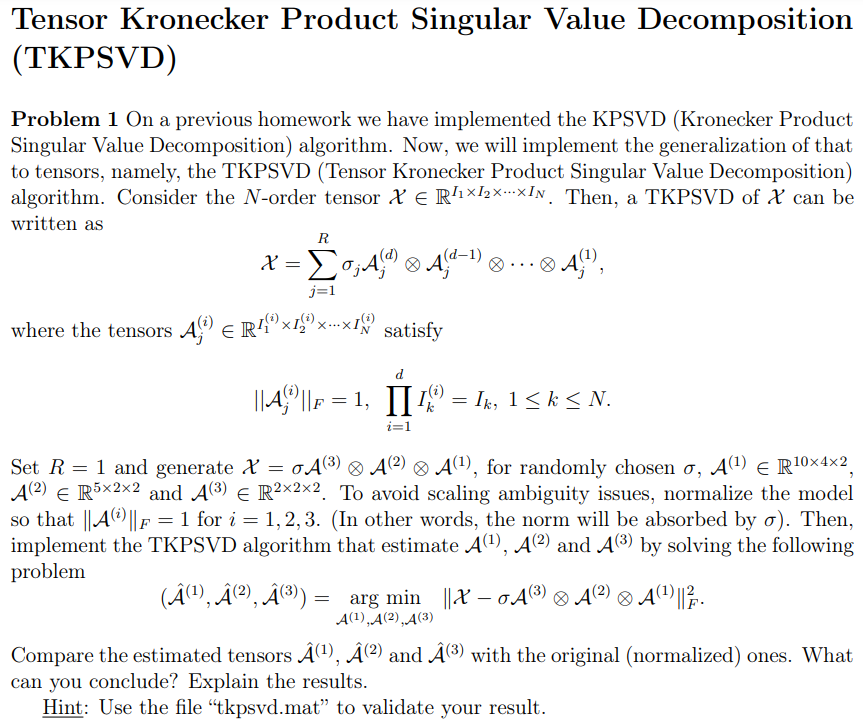

In [10]:
import numpy as np
import tensorly as tl
import multilinear_algebra as ma
import matplotlib.pyplot as plt
from typing import Union
from scipy.io import loadmat
from scipy.linalg import khatri_rao as kr


# Testing with krd_matrix_3D.mat file:
mat_file = loadmat(r"C:\Users\Administrador\Documents\Doutorado\Algebra tensorial\Homeworks\matlab files\tkpsvd.mat")

A1 = mat_file['tenA1'][0][0][0]
A2 = mat_file['tenA2'][0][0][0]
A3 = mat_file['tenA3'][0][0][0]
sigma = mat_file['sigma'][0][0]
X = tl.tenalg.kronecker([A3, A2, A1])

print(f'X shape: {X.shape}')
print(f'A1 shape: {A1.shape}')
print(f'A2 shape: {A2.shape}')
print(f'A3 shape: {A3.shape}')

X shape: (100, 16, 8)
A1 shape: (10, 4, 2)
A2 shape: (5, 2, 2)
A3 shape: (2, 2, 2)


In [15]:
def compute_X_tilde(X, A1_shape, A2_shape, A3_shape):
    """
    Computes the tensor X_tilde following the steps from the TKPSVD method.

    Parameters:
    X : ndarray
        The input tensor X, computed as the Kronecker product of A3, A2, and A1.
    A1_shape : tuple
        Shape of matrix A1 (i1, i2, i3).
    A2_shape : tuple
        Shape of matrix A2 (j1, j2, j3).
    A3_shape : tuple
        Shape of matrix A3 (k1, k2, k3).

    Returns:
    X_tilde : ndarray
        The reshaped and permuted tensor.
    """

    # Step 1: Extract dimensions
    i1, i2, i3 = A1_shape
    j1, j2, j3 = A2_shape
    k1, k2, k3 = A3_shape

    # Step 2: Reshape X into a 9th-order tensor
    kronecker_order = (i1, j1, k1, i2, j2, k2, i3, j3, k3)
    X_aux = X.reshape(kronecker_order, order='F')

    # Step 3: Permute indices into the desired order (i1, i2, i3, j1, j2, j3, k1, k2, k3)
    def permute_rule(n):
        """Create permutation rule based on the order of indices."""
        order = int(np.sqrt(n))
        return tuple([(i % order) * order + (i // order) for i in range(n)])

    # Permutation rule for 9-order tensor
    rule_permute = permute_rule(9)
    X_aux = np.transpose(X_aux, rule_permute).copy(order='F')

    # Step 4: Reshape into a 3rd-order tensor
    X_tilde = X_aux.reshape(np.prod(A1_shape), np.prod(A2_shape), np.prod(A3_shape), order='F')

    return X_tilde

# simplified ALS function from homework 11 (problem 1)
def als(X, rank, n_runs=10000, delta=1e-6):
    
    _, B_row, C_row = X.shape
    B_hat = np.random.randn(B_row, rank)
    C_hat = np.random.randn(C_row, rank)

    X_1 = ma.unfold(X, 1)
    X_2 = ma.unfold(X, 2)
    X_3 = ma.unfold(X, 3)

    error = np.zeros([n_runs])
    error[0] = 0
    
    for i in range(1, n_runs):
        A_hat = X_1 @ np.linalg.pinv(kr(C_hat, B_hat).T)
        B_hat = X_2 @ np.linalg.pinv(kr(C_hat, A_hat).T)
        C_hat = X_3 @ np.linalg.pinv(kr(B_hat, A_hat).T)

        error[i] = np.linalg.norm(X_1 - A_hat @ (kr(C_hat, B_hat).T), 'fro')
        
        if abs(error[i] - error[i - 1]) <= delta:
            print(f'Converged  with error {abs(error[i] - error[i - 1])}')
            break

    return A_hat, B_hat, C_hat

In [16]:
# Computing X_tilde its shape should be i1*i2*i3, j1*j2*j3, k1*k2*k3 (80,20,8) 
X_tilde = compute_X_tilde(X, A1.shape, A2.shape, A3.shape)
X_tilde.shape

(80, 20, 8)

In [17]:
# Checking rank of X_tilde
np.linalg.matrix_rank(ma.unfold(X_tilde,1))

np.int64(1)

In [18]:
# Estimating A1 A2 A3 with als
A1_hat, A2_hat, A3_hat = als(X_tilde,1)

Converged  with error 1.3506755275784832e-14


In [19]:
# Checking shapes
print(f'A1_hat shape: {A1_hat.shape}')
print(f'A2_hat shape: {A2_hat.shape}')
print(f'A3_hat shape: {A3_hat.shape}')

A1_hat shape: (80, 1)
A2_hat shape: (20, 1)
A3_hat shape: (8, 1)


Parece que os A1 A2 A3 estimados precisam passar por um fold para volatem as dimensões originais

In [20]:
# Folding back to original dimensions
A1_hat_final = ma.fold(A1_hat,A1.shape,1)
A2_hat_final = ma.fold(A2_hat,A2.shape,1)
A3_hat_final = ma.fold(A3_hat,A3.shape,1)

In [24]:
# Checking approximations of the first element of each tensor
print('A/A_hat')
print(f'{A1[0]/A1_hat_final[0]}\n')

print('B/B_hat')
print(f'{A2[0]/A2_hat_final[0]}\n')

print('C/C_hat')
print(f'{A3[0]/A3_hat_final[0]}')

A/A_hat
[[219.70771723 219.70771723]
 [219.70771723 219.70771723]
 [219.70771723 219.70771723]
 [219.70771723 219.70771723]]

B/B_hat
[[0.03799694 0.03799694]
 [0.03799694 0.03799694]]

C/C_hat
[[0.119786 0.119786]
 [0.119786 0.119786]]


Nota-se que, assim como no homework 11, há um fator de escala em cada estimativa de A1 A2 A3, portanto, para que a aproximação de A1_hat A2_hat A3_hat seja mais próxima da realidade, é necessário conhecer a priori alguma informação das matrizes A1 A2 A3, por exemplo, caso seja conhecida o primeiro elemento de A1 A2 A3:

In [27]:
scaling_factor_a1 = A1[0][0][0]/A1_hat_final[0][0][0]
scaling_factor_a2 = A2[0][0][0]/A2_hat_final[0][0][0]
scaling_factor_a3 = A3[0][0][0]/A3_hat_final[0][0][0]

# Applying scaling factor and calculating NMSE
A1_hat_scaled = scaling_factor_a1 * A1_hat_final
print("NMSE (A1_hat) = ", ma.NMSE(A1,A1_hat_scaled))

# Applying scaling factor and calculating NMSE
A2_hat_scaled = scaling_factor_a2 * A2_hat_final
print("NMSE (A2_hat) = ", ma.NMSE(A2,A2_hat_scaled))

# Applying scaling factor and calculating NMSE
A3_hat_scaled = scaling_factor_a3 * A3_hat_final
print("NMSE (A3_hat) = ", ma.NMSE(A3,A3_hat_scaled))

NMSE (A1_hat) =  4.755311120010533e-31
NMSE (A2_hat) =  1.767508987331658e-31
NMSE (A3_hat) =  1.1935036074106951e-31


Portanto, conhecendo-se pelo menos as dimensões de A1 A2 A3 e pelo menos 1 dos elementos de cada um, é possível estimar cada tensor.

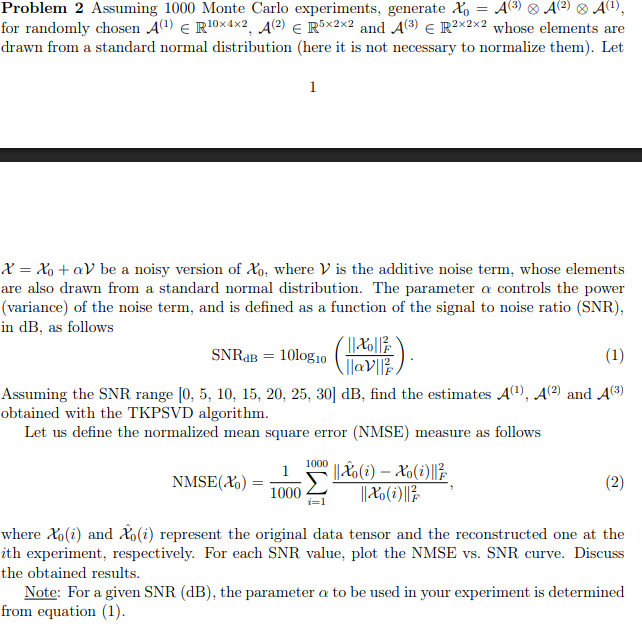

In [72]:
# Defining ALS function again with a few tweaks
def als(X, rank, SNR_dB=None, n_runs=10000, delta=1e-6):
    """
    Performs Alternating Least Squares (ALS) decomposition on a 3-way tensor.

    This function decomposes a 3-way tensor `X` into three factor matrices 
    (A_hat, B_hat, C_hat) using the Alternating Least Squares (ALS) algorithm.
    It incorporates optional noise addition and scaling based on known values.

    Args:
        X (numpy.ndarray): The 3-way tensor to decompose.
        rank (int): The desired rank of the decomposition (number of components).
        known_values (list or tuple, optional): A tuple or list of three values. 
            These are used to scale the resulting factor matrices. 
        SNR_dB (float, optional): Signal-to-noise ratio in decibels. If provided, 
            additive white Gaussian noise (AWGN) is added to the tensor `X` before 
            decomposition. If None, no noise is added. Defaults to None.
        n_runs (int, optional): The maximum number of iterations for the ALS algorithm. 
            Defaults to 10000.
        delta (float, optional): The convergence tolerance. The algorithm stops when the 
            relative change in the reconstruction error between iterations is less than `delta`.
            Defaults to 1e-6.

    Returns:
        tuple: A tuple containing the scaled factor matrices (A_hat_scaled, B_hat_scaled, C_hat_scaled).
    """
    _, B_row, C_row = X.shape
    B_hat = np.random.randn(B_row, rank)
    C_hat = np.random.randn(C_row, rank)
    
    # Adding AWGN noise:
    if SNR_dB != None:
        X_noisy = ma.fold(ma.alphaV(ma.unfold(X,1), SNR_dB), X.shape, 1) 
        X = X + X_noisy
    else:
        pass
    
    X_1 = ma.unfold(X, 1)
    X_2 = ma.unfold(X, 2)
    X_3 = ma.unfold(X, 3)

    error = np.zeros([n_runs])
    error[0] = 0
    
    for i in range(1, n_runs):
        A_hat = X_1 @ np.linalg.pinv(kr(C_hat, B_hat).T)
        B_hat = X_2 @ np.linalg.pinv(kr(C_hat, A_hat).T)
        C_hat = X_3 @ np.linalg.pinv(kr(B_hat, A_hat).T)

        error[i] = np.linalg.norm(X_1 - A_hat @ (kr(C_hat, B_hat).T), 'fro')
        
        if abs(error[i] - error[i - 1]) <= delta:
            #print(f'Converged  with error {abs(error[i] - error[i - 1])}')
            break

    return A_hat, B_hat, C_hat

In [74]:
i1, i2, i3 = 10, 4, 2
j1, j2, j3 =  5, 2, 2
k1, k2, k3 =  2, 2, 2

SNR_dB_range = [0, 5, 10, 15, 20, 25, 30]
num_experiments = 1000

nmse_results_a1 = np.zeros((num_experiments, len(SNR_dB_range)))
nmse_results_a2 = np.zeros((num_experiments, len(SNR_dB_range)))
nmse_results_a3 = np.zeros((num_experiments, len(SNR_dB_range)))

for ind_run in range(num_experiments):
    #print(ind_run)
    for snr_idx, snr in enumerate(SNR_dB_range):
        A1 = np.random.randn(i1, i2, i3)
        A2 = np.random.randn(j1, j2, j3)
        A3 = np.random.randn(k1, k2, k3)
        X = tl.tenalg.kronecker([A3, A2, A1])
        X_tilde = compute_X_tilde(X, A1.shape, A2.shape, A3.shape)
        
        # Running the ALS:
        A1_hat, A2_hat, A3_hat = als(X_tilde, 1, snr)

        # Folding back to original dimensions
        A1_hat_final = ma.fold(A1_hat,A1.shape,1)
        A2_hat_final = ma.fold(A2_hat,A2.shape,1)
        A3_hat_final = ma.fold(A3_hat,A3.shape,1)

        # Assigining scaling factor based on known element
        scaling_factor_a1 = A1[0][0][0]/A1_hat_final[0][0][0]
        scaling_factor_a2 = A2[0][0][0]/A2_hat_final[0][0][0]
        scaling_factor_a3 = A3[0][0][0]/A3_hat_final[0][0][0]

        A1_hat_scaled = scaling_factor_a1 * A1_hat_final
        A2_hat_scaled = scaling_factor_a2 * A2_hat_final
        A3_hat_scaled = scaling_factor_a3 * A3_hat_final
        
        # Calculating NMSE from A1_hat A2_hat A3_hat:
        nmse_results_a1[ind_run, snr_idx] = ma.NMSE(A1, A1_hat_scaled)
        nmse_results_a2[ind_run, snr_idx] = ma.NMSE(A2, A2_hat_scaled)
        nmse_results_a3[ind_run, snr_idx] = ma.NMSE(A3, A3_hat_scaled)

# Take the MIN of the independent runs
# Not taking the mean because the NMSE values are yielding a high variance,
# compromising the objective of the problem at hand
nmse_results_a1 = nmse_results_a1.min(axis=0)
nmse_results_a2 = nmse_results_a2.min(axis=0)
nmse_results_a3 = nmse_results_a3.min(axis=0)

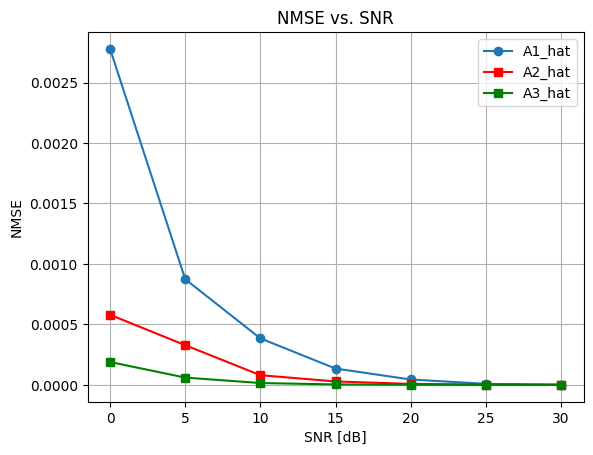

In [75]:
# Plotting
_ = plt.figure()  # Create a new figure for clarity

# Plot results for the first set of parameters
plt.plot(SNR_dB_range, nmse_results_a1, marker='o', label='A1_hat')

# Plot results for the second set of parameters
plt.plot(SNR_dB_range, nmse_results_a2, marker='s', color='red', label='A2_hat')

# Plot results for the second set of parameters
plt.plot(SNR_dB_range, nmse_results_a3, marker='s', color='green', label='A3_hat')

plt.grid(True, which="both")
plt.xlabel("SNR [dB]")
plt.ylabel("NMSE")
plt.legend()
plt.title("NMSE vs. SNR")
plt.show()

A conclusão aqui segue o mesmo caminho do que no homework 11, ou seja, de acordo com os resultados do gráfico, quanto maiores as dimensões das matrizes A1 A2 A3 matriz, mais díficil é estimá-la com precisão, especialmente na presença de ruído.